In [1]:
import numpy as np
import matplotlib.pyplot as plt
from astropy.table import Table, vstack
from astropy import units as u
from astropy.coordinates import SkyCoord
from pykoa.koa import Koa
from tqdm.auto import tqdm

In [2]:
hires_obs = Table.read('koa_out/all.csv')
sample = Table.read('ollie_stars_w_hires.csv')

In [3]:
#sample = np.genfromtxt('Gr8stars_GaiaeDR3_TIC.tsv', delimiter='\t', names=True, dtype=None, encoding=None)

In [4]:
sample = Table.read('Gr8stars_GaiaeDR3_TIC_hires.csv')

In [6]:
print('{0} stars queried:'.format(len(sample)))
print('no HIRES spectra at all: {0}'.format(np.sum(sample['n_hires_obs_all'] == 0)))
print('no suitable HIRES spectra: {0}'.format(np.sum(sample['n_hires_obs_iodout'] == 0)))
print('suitable HIRES spectra exist: {0}'.format(np.sum(sample['n_hires_obs_iodout'] > 0)))

2858 stars queried:
no HIRES spectra at all: 1474
no suitable HIRES spectra: 1843
suitable HIRES spectra exist: 1015


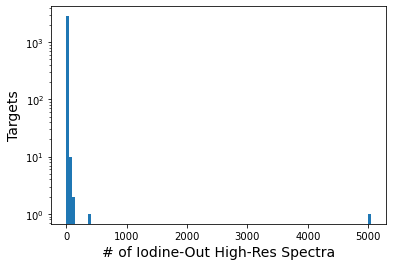

In [7]:
plt.hist(sample['n_hires_obs_iodout'], bins=100)
plt.yscale('log')
plt.xlabel('# of Iodine-Out High-Res Spectra', fontsize=14)
plt.ylabel('Targets', fontsize=14);

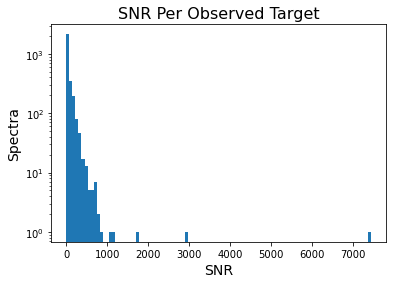

In [8]:
plt.hist(sample['hires_snr'][sample['hires_snr'] >= 0], bins=100)
plt.yscale('log')
plt.title('SNR Per Observed Target', fontsize=16)
plt.xlabel('SNR', fontsize=14)
plt.ylabel('Spectra', fontsize=14);

In [9]:
# cut on SNR:
min_snr = 100.
good_sample = sample[sample['hires_snr'] >= min_snr]

In [10]:
print('after SNR cut:')
print('suitable HIRES spectra exist: {0}'.format(len(good_sample)))

after SNR cut:
suitable HIRES spectra exist: 586


In [11]:
ok_sample = sample[sample['n_hires_obs_iodout'] > 0]

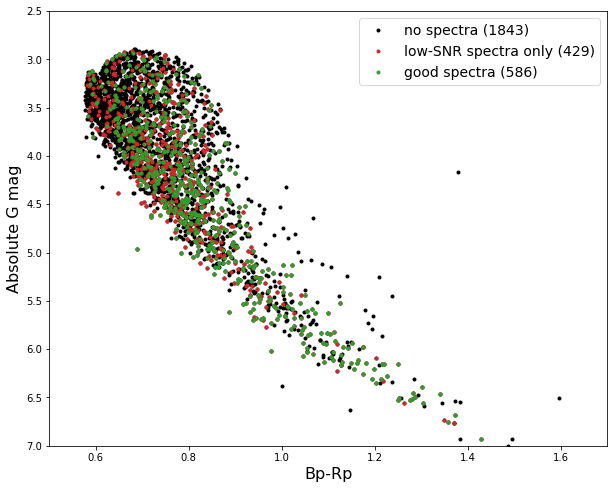

In [12]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ms = 6
ax.plot(sample['BPRP'], sample['Gmag'] + 5.*(np.log10(sample['Plx']/1.e3)+1), c='k', marker='.', ls='', ms=ms, 
        label='no spectra ({0})'.format(len(sample) - len(ok_sample)))
ax.plot(ok_sample['BPRP'], ok_sample['Gmag'] + 5.*(np.log10(ok_sample['Plx']/1.e3)+1), c='C3', marker='.', ls='', ms=ms, 
        label='low-SNR spectra only ({0})'.format(len(ok_sample) - len(good_sample)))
ax.plot(good_sample['BPRP'], good_sample['Gmag'] + 5.*(np.log10(good_sample['Plx']/1.e3)+1), c='C2', marker='.', ls='', ms=ms, 
        label='good spectra ({0})'.format(len(good_sample)))
ax.set_ylim([7,2.5])
ax.set_xlim([0.5,1.7])
plt.legend(fontsize=14)
ax.set_xlabel('Bp-Rp', fontsize=16)
ax.set_ylabel('Absolute G mag', fontsize=16)
plt.savefig('hires_cmag_snr100.png');

In [13]:
# cut on SNR:
min_snr = 200.
good_sample = sample[sample['hires_snr'] >= min_snr]

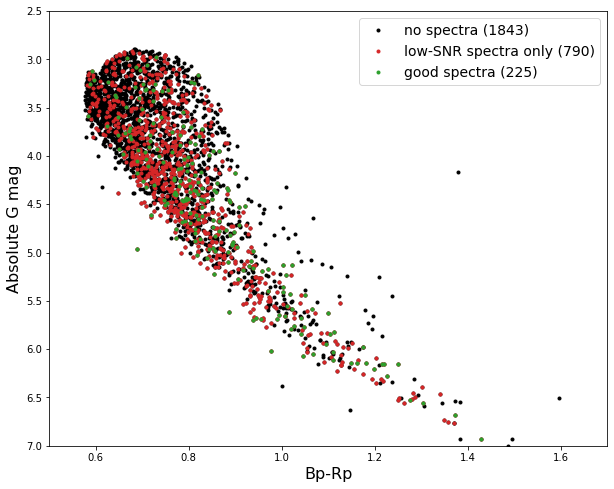

In [14]:
fig, ax = plt.subplots(1, 1, figsize=(10,8))
ms = 6
ax.plot(sample['BPRP'], sample['Gmag'] + 5.*(np.log10(sample['Plx']/1.e3)+1), c='k', marker='.', ls='', ms=ms, 
        label='no spectra ({0})'.format(len(sample) - len(ok_sample)))
ax.plot(ok_sample['BPRP'], ok_sample['Gmag'] + 5.*(np.log10(ok_sample['Plx']/1.e3)+1), c='C3', marker='.', ls='', ms=ms, 
        label='low-SNR spectra only ({0})'.format(len(ok_sample) - len(good_sample)))
ax.plot(good_sample['BPRP'], good_sample['Gmag'] + 5.*(np.log10(good_sample['Plx']/1.e3)+1), c='C2', marker='.', ls='', ms=ms, 
        label='good spectra ({0})'.format(len(good_sample)))
ax.set_ylim([7,2.5])
ax.set_xlim([0.5,1.7])
plt.legend(fontsize=14)
ax.set_xlabel('Bp-Rp', fontsize=16)
ax.set_ylabel('Absolute G mag', fontsize=16)
plt.savefig('hires_cmag_snr200.png');